In [4]:
import pandas as pd
import os
import numpy as np
# add reading window size as part of code
wsize=80
%matplotlib inline
os.chdir('/Users/vinayswamy/NIH/eyesplice_predictor')
pd.core.common.random_state(None)
np.random.seed(8123)


In [6]:
col_names=['seqid', 'wstart','wend','ID']+list(range(80))
c_cols=list(range(80))
df=pd.read_csv('/Users/vinayswamy/NIH/eyesplice_predictor/data/cleaned_cov/RPE_Fetal.Tissue/HM7FMBBXX_16424750_S70_bp_features.tsv.gz', 
               sep='\t', header=None, names=col_names)

In [7]:
df.shape

(160840, 84)

In [10]:
df.head()

,seqid,wstart,wend,ID,0,1,2,3,4,5,...,70,71,72,73,74,75,76,77,78,79
0,chr1,11891,11971,exon_0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,chr1,14421,14501,exon_7,1,1,1,1,1,1,...,3,3,3,3,3,3,3,3,3,3
2,chr1,16621,16701,exon_6,7,7,7,6,6,6,...,3,2,2,2,3,3,3,3,3,3
3,chr1,17328,17408,ref_EL_1,61,59,59,59,59,59,...,30,30,30,30,31,31,32,32,32,31
4,chr1,17652,17732,exon_5,76,75,77,76,77,82,...,84,82,80,80,81,79,78,78,77,74


In [11]:
lab_col=df['ID'].str.replace('\d+','')
pd.Series(lab_col).value_counts()

exon_      40210
intron_    40210
ref_SL_    20160
SL_        20117
EL_        20093
ref_EL_    20050
Name: ID, dtype: int64

In [6]:
'''
need to do 3 things - reverse the SL columns,make label column, and remove low count features
for removing low counts, going to switch to doing it  piece by piece
'''
sl=df[df['ID'].str.contains('SL')].reset_index(drop=True)
el=df[df['ID'].str.contains('EL')].reset_index(drop=True)
intron=df[df['ID'].str.contains('intron')].reset_index(drop=True)
exon=df[df['ID'].str.contains('exon')].reset_index(drop=True)
rev_idx= ['seqid','wstart','wend','ID']+list(range(79,-1,-1))
sl_rev=sl.loc[:,rev_idx]
sl_rev.columns=col_names
all_junc=pd.concat([el, sl_rev]).reset_index(drop=True)
keep_junc=all_junc.loc[:, c_cols].sum(axis=1) >=80
all_junc=all_junc[keep_junc]
keep_exon=exon.loc[:,c_cols].sum(axis=1) >=80
exon=exon[keep_exon]
intron_sums=intron.loc[:,c_cols].sum(axis=1)
intron_sums.quantile([.1,.2,.3,.4,.6,.7,.8,.9, 1])# mjority are 0, but i'll keep it up till 20 for sake of completeness.
keep_intron=intron_sums <= 20
intron=intron[keep_intron]

min_count= min(all_junc.ID.str.contains('ref').sum(),
              all_junc.shape[0]-all_junc.ID.str.contains('ref').sum() ,
              intron.shape[0],
              exon.shape[0])
complete_data=pd.concat([all_junc[all_junc['ID'].str.contains('ref')].sample(min_count, ),
                         all_junc[~all_junc['ID'].str.contains('ref')].sample(min_count),
                         intron.sample(min_count),
                         exon.sample(min_count)
                        ]).reset_index()

lab_col=list()
'''
0=alt_splice junctino
1=no_splice junction
2=exon
3=not exon
'''
for lab in complete_data['ID']:
    if 'intron' in lab:
        lab_col.append(3)
    elif 'exon' in lab:
        lab_col.append(2)
    elif 'ref' in lab:
        lab_col.append(1)
    else:
        lab_col.append(0)

complete_data['Y']=lab_col


In [7]:
complete_data['Y'].value_counts()

3    11412
2    11412
1    11412
0    11412
Name: Y, dtype: int64

In [8]:
# above wrapped into a function for multiple sample use.
def pre_process(path, cut_off=wsize):
    col_names=['seqid', 'wstart','wend','ID']+list(range(80))
    c_cols=list(range(80))
    df=pd.read_csv(path, sep='\t', header=None, names=col_names)
    sl=df[df['ID'].str.contains('SL')].reset_index(drop=True)
    el=df[df['ID'].str.contains('EL')].reset_index(drop=True)
    intron=df[df['ID'].str.contains('intron')].reset_index(drop=True)
    exon=df[df['ID'].str.contains('exon')].reset_index(drop=True)
    rev_idx= ['seqid','wstart','wend','ID']+list(range(79,-1,-1))
    sl_rev=sl.loc[:,rev_idx]
    sl_rev.columns=col_names
    all_junc=pd.concat([el, sl_rev]).reset_index(drop=True)
    keep_junc=all_junc.loc[:, c_cols].sum(axis=1) >=80
    all_junc=all_junc[keep_junc]
    keep_exon=exon.loc[:,c_cols].sum(axis=1) >=80
    exon=exon[keep_exon]
    intron_sums=intron.loc[:,c_cols].sum(axis=1)
    intron_sums.quantile([.1,.2,.3,.4,.6,.7,.8,.9, 1])# majority are 0, but i'll keep it up till 20 for sake of completeness.
    keep_intron=intron_sums <= 20
    intron=intron[keep_intron]

    min_count= min(all_junc.ID.str.contains('ref').sum(),
                  all_junc.shape[0]-all_junc.ID.str.contains('ref').sum() ,
                  intron.shape[0],
                  exon.shape[0])
    complete_data=pd.concat([all_junc[all_junc['ID'].str.contains('ref')].sample(min_count, ),
                             all_junc[~all_junc['ID'].str.contains('ref')].sample(min_count),
                             intron.sample(min_count),
                             exon.sample(min_count)
                            ]).reset_index(drop=True)

    lab_col=list()
    '''
    0=alt_splice junctino
    1=no_splice junction
    2=exon
    3=not exon
    '''
    for lab in complete_data['ID']:
        if 'intron' in lab:
            lab_col.append(3)
        elif 'exon' in lab:
            lab_col.append(2)
        elif 'ref' in lab:
            lab_col.append(1)
        else:
            lab_col.append(0)

    complete_data['Y']=lab_col
    return(complete_data)

In [9]:
data_1=pre_process('data/cleaned_cov/HM7FMBBXX_16496356_S52_bp_features.tsv.gz')
data_2=pre_process('data/cleaned_cov/HM7FMBBXX_16496358_S54_bp_features.tsv.gz')
data_3=pre_process('data/cleaned_cov/HM7FMBBXX_16496360_S56_bp_features.tsv.gz')

In [22]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
x_cols=list(range(80))
X=data_1.loc[:,x_cols]
Y=data_1['Y']
pca=PCA(n_components=2)
pcmat=pca.fit_transform(X)
drX=pd.DataFrame(data=pcmat ,columns=['PC1', 'PC2']).assign(lab=Y)

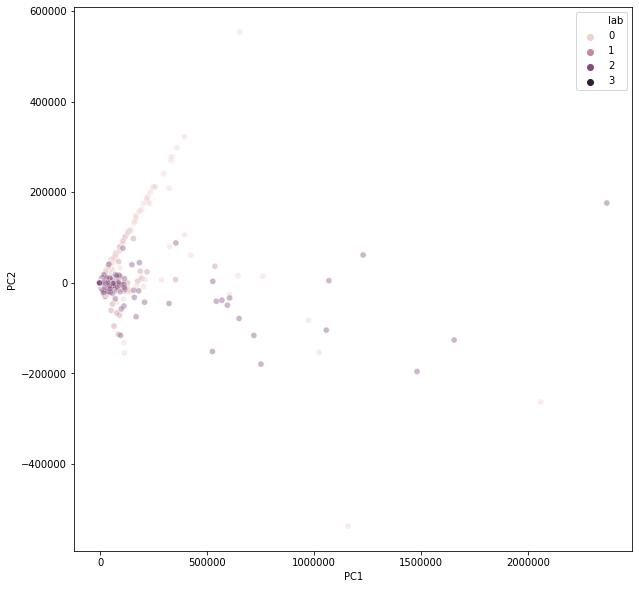

In [66]:
%matplotlib inline
plt.figure(figsize=(10,10))
sns.scatterplot(data=drX, x='PC1', y='PC2', hue='lab', alpha=.4)

In [67]:
pca.explained_variance_ratio_

array([0.90865101, 0.06839068])

PCA does not look that great,and I didn't boff the labels/ orientation, which leads me to ask, do we really need bp level info? may haps just the averages will work.

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix , roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from xgboost import XGBClassifier
import pandas_ml as pml

def ROC_plot(Y_test, Y_prob):
    fpr, tpr, thresholds=roc_curve(Y_test, Y_prob)
    auc=roc_auc_score(Y_test, Y_prob)
    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
def PR_plot(Y_test, Y_prob):
    pre, rec, thresholds = precision_recall_curve(Y_test, Y_prob)
    auc = average_precision_score(Y_test, Y_prob)
    plt.plot(rec, pre, label=' Prec/Rec (area = %0.2f)' % ( auc))
    plt.plot([1, 1], [1, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('')
    plt.legend(loc="lower right")
    plt.show()   

def train_model(X,Y, model):
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=.3, random_state=8976, stratify=Y)
    model.fit(X_train, Y_train)
    Y_pred=model.predict(X_test)
    Y_prob=model.predict_proba(X_test)[:,1]
    labs=model.classes_
    print('confusion matrix\n\n')
    print(pd.DataFrame(confusion_matrix(Y_test, Y_pred), index=labs, columns=labs))
    print('\n\nclassification report\n\n')
    print(classification_report(y_pred=Y_pred,y_true=Y_test))
    ROC_plot(Y_test , Y_prob)
    PR_plot(Y_test,Y_prob)
    return(model)

In [24]:
model=XGBClassifier(random_state=2234)
model_names=['Random Forest', 'XGBC', 'KNN']
X_1=data_1.loc[:,x_cols]
Y_1=data_1['Y']
trained_model= train_model(X_1, Y_1, model)
# Y_1.value_counts()
# X_train, X_test, Y_train, Y_test = train_test_split(X_1,Y_1, test_size=.3, random_state=8976, stratify=Y_1)
# model.fit(X_train, Y_train)


NameError: name 'data_1' is not defined

In [25]:
'''
okay well thats clearly not working
it can easily pick out an exon, but makes sense that the distinction between half an exon and a whole exon vs an alt splice exon is not that clear, so we'll try a couple of things
-log transform
-separate clases and retrain
-prune training data a little more, but I'm hesitant to do this cause It'll overfit the model
'''
juncs=data_2.query('Y == 0 | Y==1')
model=XGBClassifier(random_state=2234)
X_j=juncs.loc[:,x_cols]
Y_j=juncs['Y']
m=train_model(X_j, Y_j, model)

NameError: name 'data_2' is not defined

In [22]:
k=pd.DataFrame([[2,2],[3,3]])
print(k)
k.sum(axis=0)

   0  1
0  2  2
1  3  3


0    5
1    5
dtype: int64

In [23]:
old_data=pd.read_csv('/Volumes/data/eyeintegration_splicing/data/cleaned_cov/HM7FMBBXX_16424750_S70_bp_features.tsv.gz',sep='\t', header=None, names=col_names) 

In [12]:
sl=df[df['ID'].str.contains('SL')].reset_index(drop=True)
el=df[df['ID'].str.contains('EL')].reset_index(drop=True)
rev_idx= ['seqid','wstart','wend','ID']+list(range(79,-1,-1))
sl_rev=sl.loc[:,rev_idx]
sl_rev.columns=col_names
all_junc=pd.concat([el, sl_rev]).reset_index(drop=True)
keep_junc=all_junc.loc[:, c_cols].sum(axis=1) >=80
all_junc=all_junc[keep_junc]


min_count= min(all_junc.ID.str.contains('ref').sum(),
                  all_junc.shape[0]-all_junc.ID.str.contains('ref').sum() ,
                 )
complete_data=all_junc
lab_col=list()

complete_data=pd.concat([all_junc[all_junc['ID'].str.contains('ref')].sample(min_count, ),
                         all_junc[~all_junc['ID'].str.contains('ref')].sample(min_count),
                        ]).reset_index(drop=True)
'''
0=alt_splice junctino
1=no_splice junction
2=exon
3=not exon
'''
for lab in complete_data['ID']:
    if 'intron' in lab:
        lab_col.append(3)
    elif 'exon' in lab:
        lab_col.append(2)
    elif 'ref' in lab:
        lab_col.append(1)
    else:
        lab_col.append(0)

complete_data['Y']=lab_col

In [13]:
complete_data['Y'].value_counts()

1    29609
0    29609
Name: Y, dtype: int64

confusion matrix


      0     1
0  6665  2218
1  1851  7032


classification report


              precision    recall  f1-score   support

           0       0.78      0.75      0.77      8883
           1       0.76      0.79      0.78      8883

    accuracy                           0.77     17766
   macro avg       0.77      0.77      0.77     17766
weighted avg       0.77      0.77      0.77     17766



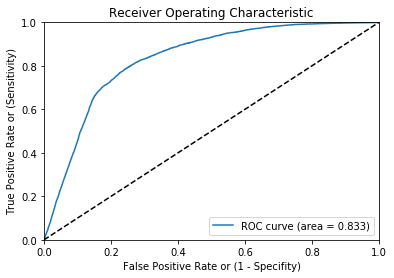

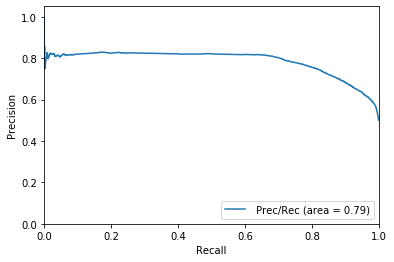

In [26]:
x_cols=list(range(80))
model_old=XGBClassifier(random_state=2234)
X_j=complete_data.loc[:,x_cols]
Y_j=complete_data['Y']
m=train_model(X_j, Y_j, model_old)


confusion matrix


      0     1
0  6665  2218
1  1851  7032


classification report


              precision    recall  f1-score   support

           0       0.78      0.75      0.77      8883
           1       0.76      0.79      0.78      8883

    accuracy                           0.77     17766
   macro avg       0.77      0.77      0.77     17766
weighted avg       0.77      0.77      0.77     17766



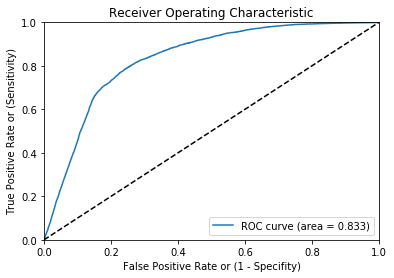

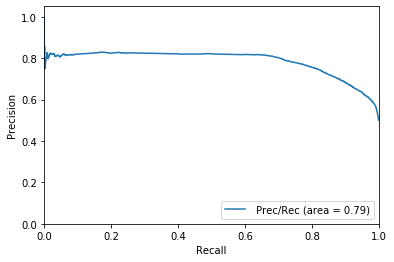

In [28]:
lc_data=np.log2(complete_data.loc[:,x_cols] + 1 )

model_lc=XGBClassifier(random_state=2234)
X_j=lc_data
Y_j=complete_data['Y']
m=train_model(X_j, Y_j, model_lc)


In [29]:
lc_data.head()

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,7.076816,7.076816,7.076816,7.076816,7.033423,6.988685,6.977280,6.954196,6.918863,6.942515,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,4.643856,4.643856,4.643856,4.643856,4.643856,4.643856,4.643856,4.643856,4.643856,4.643856,...,1.584963,1.584963,1.584963,1.584963,1.584963,1.584963,1.584963,1.584963,1.584963,1.584963
2,7.022368,7.033423,7.055282,7.044394,7.044394,7.033423,7.022368,7.022368,7.033423,7.044394,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,3.807355,3.807355,3.807355,3.807355,3.807355,3.807355,3.807355,3.807355,3.807355,3.700440,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,5.584963,5.584963,5.584963,5.554589,5.491853,5.491853,5.392317,5.392317,5.459432,5.523562,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [37]:
complete_data.sort_values(['seqid', 'wstart']).head()

,seqid,wstart,wend,ID,0,1,2,3,4,5,...,71,72,73,74,75,76,77,78,79,Y
4893,chr1,939000,939080,ref_SL_130818,7,7,7,7,7,7,...,0,0,0,0,0,0,0,0,0,1
30935,chr1,939372,939452,EL_515,10,10,10,10,10,10,...,3,4,4,4,4,4,4,4,4,0
31523,chr1,941190,941270,EL_516,7,7,7,7,7,7,...,6,7,7,6,6,7,7,7,7,0
13484,chr1,943018,943098,ref_EL_89286,8,7,7,7,7,7,...,1,1,1,1,1,1,1,1,1,1
235,chr1,943337,943417,ref_EL_14516,3,3,3,3,3,3,...,0,0,0,0,0,0,0,0,0,1


In [38]:
data_2.sort_values(['seqid', 'wstart']).head(10)

,seqid,wstart,wend,ID,0,1,2,3,4,5,...,71,72,73,74,75,76,77,78,79,Y
21031,chr1,13334,13414,EL_0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
59159,chr1,14411,14491,exon_6,4,4,4,4,4,4,...,7,7,5,5,5,5,5,6,6,2
56803,chr1,15819,15899,exon_5,3,3,2,2,2,3,...,3,3,3,3,3,2,2,2,2,2
59613,chr1,18286,18366,exon_1,22,22,22,22,22,22,...,22,22,22,21,21,20,20,20,20,2
68876,chr1,90433,90513,exon_15,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2
28289,chr1,142768,142848,SL_1346,4,4,4,4,4,4,...,0,0,0,0,0,0,0,0,0,0
18639,chr1,146469,146549,EL_1363,4,4,4,4,4,3,...,0,0,0,0,0,0,0,0,0,0
11152,chr1,184134,184214,ref_EL_15,2,2,2,2,2,2,...,0,0,0,0,0,0,0,0,0,1
69464,chr1,186342,186422,exon_27,55,55,57,59,58,58,...,46,46,44,45,46,44,44,43,40,2
71795,chr1,187425,187505,exon_26,9,9,9,9,9,9,...,13,13,13,13,13,13,13,14,14,2
